In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [3]:
class Normalizer():

    def fit_trnsform(self, X):
        self.min = X.min()
        self.max = X.max()
        self.vrange = (self.max - self.min)
        return (X - self.min) / self.vrange
    
    def denormalize(self, X):
        return (X * self.vrange) + self.min

normalizer = Normalizer()

In [4]:
def create_nn_dataset(data, w):
    data = normalizer.fit_trnsform(data)

    X = np.array([data[n: n+30] for n in range(data.shape[0]-29-w)])
    y = np.array([data[n: n+w] for n in range(30, data.shape[0]-w+1)])

    X_train, X_test, y_train, y_test = train_test_split(X[:-10], y[:-10], test_size=0.2)
    X_test = np.append(X_test, X[-10:], axis=0)
    y_test = np.append(y_test, y[-10:], axis=0)

    return X_train, X_test, y_train, y_test

In [5]:
df_litecoin = pd.read_csv('drive/MyDrive/NNDL/extra/Monero Historical Data.csv')
df_litecoin.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 09, 2023",153.791,153.456,155.379,152.207,71.04K,0.22%
1,"May 08, 2023",153.456,156.893,157.508,149.362,86.26K,-2.19%
2,"May 07, 2023",156.893,156.203,158.577,155.794,52.59K,0.44%
3,"May 06, 2023",156.203,158.282,158.949,154.127,70.31K,-1.31%
4,"May 05, 2023",158.282,155.491,158.577,154.700,80.10K,1.80%


In [6]:
def preprocess_and_get_datasets(df):
    X = df['Price'][::-1].to_numpy(dtype=np.float32)
    return create_nn_dataset(X, 7)

In [7]:
X_train, X_test, y_train, y_test_7d = preprocess_and_get_datasets(df_litecoin)
print(X_train.shape)
print(y_train.shape)

X_train.reshape((-1, 30, 1))
X_test.reshape((-1, 30, 1))

y_test_1d = y_test_7d[:, :1]
y_test_3d = y_test_7d[:, :3]
y_train = y_train[:, :1]

(1819, 30)
(1819, 7)


In [8]:
def build_proposed_model():
    # input layer
    input_layer = keras.layers.Input(shape=(30, 1))

    # LSTM block
    x = keras.layers.LSTM(30, return_sequences=True)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.LSTM(50)(x)
    lstm_output = keras.layers.Dense(10, activation="relu")(x)

    # GRU block
    x = keras.layers.GRU(30)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    gru_output = keras.layers.Dense(10, activation="relu")(x)

    # output layer
    x = keras.layers.Concatenate()([lstm_output, gru_output])
    output = keras.layers.Dense(1, activation="relu")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output)
    return model

proposed_model = build_proposed_model()
proposed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 30, 30)       3840        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 30)       0           ['lstm[0][0]']                   
                                                                                                  
 gru (GRU)                      (None, 30)           2970        ['input_1[0][0]']                
                                                                                              

In [9]:
def build_comparison_model():
    # input layer
    input_layer = keras.layers.Input(shape=(30, 1))

    # LSTM block
    x = keras.layers.LSTM(50)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation="relu")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output)
    return model

comparison_model = build_comparison_model()
comparison_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
def compile_and_train_model(model, lr=0.005, batch_size=32, epochs=100):

    # learning rate scheduler
    steps_per_epoch = np.ceil(X_train.shape[0] / batch_size).astype(int)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(lr,
        decay_steps=steps_per_epoch, decay_rate=0.75, staircase=True)

    # loss function and optimizer
    mse = keras.losses.MeanSquaredError()
    adam = keras.optimizers.Adam(learning_rate=lr_schedule)

    # compile model
    model.compile(optimizer=adam, loss=mse, metrics=['mse', 'mae'])

    # train model
    history = model.fit (
        X_train, y_train, 
        batch_size=batch_size, epochs=epochs)

    return history

In [11]:
history_1 = compile_and_train_model(proposed_model)

Epoch 1/100
57/57 [==============================] - 23s 37ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0537
Epoch 2/100
57/57 [==============================] - 2s 37ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0268
Epoch 3/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0247
Epoch 4/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0236
Epoch 5/100
57/57 [==============================] - 4s 67ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0222
Epoch 6/100
57/57 [==============================] - 3s 45ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0210
Epoch 7/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0207
Epoch 8/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0200
Epoch 9/100
57/57 [==============================] - 2s 37ms/step - loss: 9.8172e-04 - mse: 9.8172e-04 - mae: 0.0198
Epoch 10/1

In [12]:
history_2 = compile_and_train_model(comparison_model)

Epoch 1/100
57/57 [==============================] - 3s 14ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0665
Epoch 2/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0387
Epoch 3/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0349
Epoch 4/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0321
Epoch 5/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0295
Epoch 6/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0282
Epoch 7/100
57/57 [==============================] - 2s 36ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0282
Epoch 8/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0279
Epoch 9/100
57/57 [==============================] - 1s 22ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0268
Epoch 10/100
57/57 

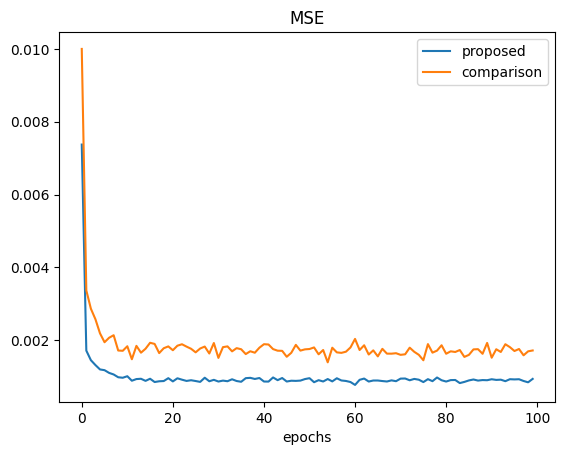

In [13]:
plt.plot(history_1.history['mse'], label='proposed')
plt.plot(history_2.history['mse'], label='comparison')
plt.legend()
plt.xlabel('epochs')
plt.title('MSE')
plt.show()

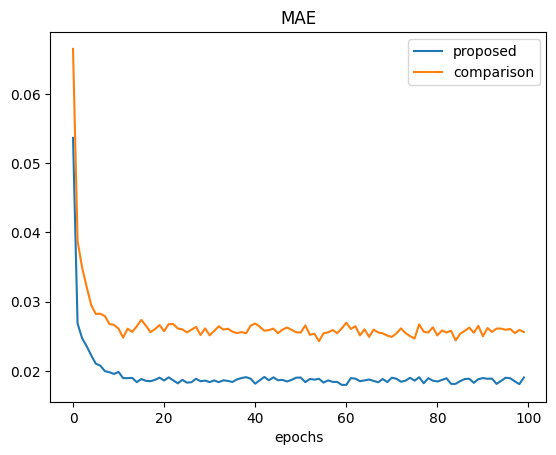

In [14]:
plt.plot(history_1.history['mae'], label='proposed')
plt.plot(history_2.history['mae'], label='comparison')
plt.legend()
plt.xlabel('epochs')
plt.title('MAE')
plt.show()

In [15]:
def predict(model, X_test, w):
    yp = []
    for i in range(w):
        yp_tmp = model.predict(X_test, verbose=0)
        yp.append(yp_tmp)
        if i < w - 1:
            X_test = np.concatenate([X_test[:, 1:], yp_tmp], axis=1)

    return np.concatenate(yp, axis=1)

In [16]:
def compute_metrics(y_test, w):

    yp_proposed = predict(proposed_model, X_test, w)
    yp_proposed = normalizer.denormalize(yp_proposed)

    yp_comparison = predict(comparison_model, X_test, w)
    yp_comparison = normalizer.denormalize(yp_comparison)

    y = normalizer.denormalize(y_test)

    mse_proposed = np.average((yp_proposed - y)**2)
    mse_comparison = np.average((yp_comparison - y)**2)

    rmse_proposed = np.sqrt(mse_proposed)
    rmse_comparison = np.sqrt(mse_comparison)

    mae_proposed = np.average(np.abs(yp_proposed - y))
    mae_comparison = np.average(np.abs(yp_comparison - y))

    mape_proposed = np.average(np.abs((yp_proposed - y) / y))
    mape_comparison = np.average(np.abs((yp_comparison - y) / y))

    print('model name\tMSE\t\tRMSE\t\tMAE\t\tMAPE')
    print(f'proposed\t{mse_proposed:.2f}\t\t{rmse_proposed:.2f}\t\t{mae_proposed:.2f}\t\t{mape_proposed:.2f}')
    print(f'comparison\t{mse_comparison:.2f}\t\t{rmse_comparison:.2f}\t\t{mae_comparison:.2f}\t\t{mape_comparison:.2f}')

In [17]:
compute_metrics(y_test_1d, 1)

model name	MSE		RMSE		MAE		MAPE
proposed	123.30		11.10		6.76		0.06
comparison	162.31		12.74		7.61		0.06


In [18]:
compute_metrics(y_test_3d, 3)

model name	MSE		RMSE		MAE		MAPE
proposed	214.04		14.63		8.55		0.07
comparison	237.28		15.40		8.87		0.06


In [19]:
compute_metrics(y_test_7d, 7)

model name	MSE		RMSE		MAE		MAPE
proposed	393.44		19.84		11.41		0.09
comparison	413.52		20.34		11.51		0.08
